# This notebook will be focusing on timeseries forecasting using gradient boosting decision tree regression algorithms. Specifically, two packages, one from sklearn and other one from LightGBM are used. 

*Name :- Karan Nayak*

## Some general information that might be useful before proceeding ahead:- 
* The highest computation time taken by a cell in this notebook is :- 1m 30s, which does the hyperparameter search. 
* This was measured on a 4 core CPU 16GB RAM.
* Keeping above conditions in mind, there is no need to use GPUs for running this notebook.
* Libraries used are :- 
    * Sklearn
    * Pandas
    * Numpy
    * Seaborn
    * Matplotlib
    * LightGBM
        * To install directly :- *pip3 install lightgbm*
        * To install in conda env :- *conda install -c conda-forge lightgbm*

**Importing required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble
import sklearn.decomposition
import sklearn.preprocessing
import seaborn as sns
import lightgbm
np.set_printoptions(precision=6,suppress=True)

# **Some observations that might be helpful in understanding the working of the code and the concepts applied.**

*-The time series in this dataset is a multivariate time series i.e. At each time step, there ar multiple observations recorded. For e.g. in 1997, we have GDP,Labour and Wage for 10 industies, totalling to 30 feautures.*

*-In order to apply Supervised learning methods on time series models, we need to convert the dataset into a supervised learning dataset i.e. having a feature and its corresponding target. Here, in time series, if X(t) is the feature then X(t+1) becomes the target. For next row, X(t+1) is the feature and X(t+2) becomes the target.*

*-We need to decide on the window size. Window is nothing but a container of previous observations that will be used to make the next prediction. In statistical terms, it is called lag or lag size and the resulting features from it are called lag features.*

*-In this notebook you'll also see multi-step prediction i.e.predicting for multiple steps rather than just the next one.*

*-We will be trying to minimize mean squared error which can be given as :-*\
$$\frac{1}{N} \sum_{n=1}^{\\N} (y_i - \hat{y_i})^2$$

**Some of the important(optional) links to read and also which I would like to use as citations, that helped me clear lots of doubts. :-**\
* https://machinelearningmastery.com/time-series-forecasting-supervised-learning/ \
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/ \
* https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

*-Below is a small depiction of how the data will be transformed for training. You can see that, after transformation the number of observations(initial ones) are reduced by the size of window.*

| Time_Step  | $Observations$  |   |   |   |
|---|---|---|---|---|
| 1  |  $X_1$ |   |   |   |
| 2  | $X_2$  |   |   |   |
| 3 | $X_3$  |   |   |   |
| 4 | $X_4$  |   |   |   |
| 5 | $X_5$  |   |   |   |
| 6 | $X_6$  |   |   |   |

------------------------------------------------------
*With rolling window size of one, the transformed data will look something like below :-*

| Index  | $Features$  | Target  |   |   |
|---|---|---|---|---|
| 1  |  $X_1$ | $X_2$  |   |   |
| 2  | $X_2$  | $X_3$  |   |   |
| 3 | $X_3$  | $X_4$  |   |   |
| 4 | $X_4$  | $X_5$  |   |   |
| 5 | $X_5$  | $X_6$  |   |   |
| 6 | $X_6$  | $NaN$  |   |   |

*With rolling window size of two, the transformed data will look something like below :-*

| Index  | $Column_1$  | $Column_2$  | Target  |   |
|---|---|---|---|---|
| 1  |  $X_1$ | $X_2$  | $X_3$  |   |
| 2  | $X_2$  | $X_3$  |  $X_4$ |   |
| 3 | $X_3$  | $X_4$  | $X_5$  |   |
| 4 | $X_4$  | $X_5$  | $X_6$  |   |

**Reading the dataset csv file**

In [2]:
#read the data file
#df = pd.read_csv('final_data_indexed _monthly.csv',header=[0,1]) 
df = pd.read_csv('data.csv',header=[0,1]) 

#Merge the first two rows in order to make a single feature row
#with format :- 'IndustryName_PerformaceCharacteristic'
df.columns = df.columns.map('_'.join)
df = df.reset_index()

#drop unwanted column(s) and convert the data_type for index to datatime
#as it is a timeseries model, also it is easy during visualization.
df.drop('index',1,inplace=True)
df.rename(columns={"Unnamed: 0_level_0_Unnamed: 0_level_1": "Year/Month"},inplace=True)
df['Year/Month'] = pd.to_datetime(df['Year/Month'])
df.set_index('Year/Month',inplace=True)
df.head()

,Accommodation and food services _GDP,Accommodation and food services _Labour,Accommodation and food services _Wages,Construction _GDP,Construction _Labour,Construction _Wages,Educational services _GDP,Educational services _Labour,Educational services _Wages,Health care and social assistance _GDP,...,"Professional, scientific and technical services _Wages",Public administration _GDP,Public administration _Labour,Public administration _Wages,Transportation and warehousing _GDP,Transportation and warehousing _Labour,Transportation and warehousing _Wages,Utilities _GDP,Utilities _Labour,Utilities _Wages
Year/Month,,,,,,,,,,,,,,,,,,,,,
1997-01-01,27361.0,1121.4,8.81,71294.0,2533.5,17.26,68408.0,185.1,20.51,87041.0,...,18.17,83757.0,648.3,19.63,51402.0,536.1,15.93,33479.0,9.2,22.71
1997-02-01,27627.0,1149.7,8.70,71818.0,2756.9,17.21,68464.0,170.9,20.49,87582.0,...,18.01,83831.0,671.8,19.60,51959.0,519.3,15.91,33561.0,4.0,22.50
1997-03-01,27696.0,1117.6,8.63,71841.0,2459.7,17.02,68466.0,157.3,20.56,87900.0,...,18.01,83745.0,724.0,19.66,52256.0,479.3,15.99,33311.0,8.3,22.68
1997-04-01,27802.0,1099.9,8.77,72775.0,2654.5,16.78,68202.0,254.5,20.86,88259.0,...,18.17,83881.0,770.6,19.58,52576.0,522.7,15.95,33309.0,48.4,22.76
1997-05-01,27877.0,933.3,8.76,73664.0,2027.5,16.34,67931.0,653.4,20.88,88502.0,...,18.27,83891.0,793.3,19.41,53005.0,427.4,16.10,33118.0,120.1,22.43


## Defining some functions below to avoid code replication.

In [3]:
#Below function transforms data into supervised learning structure for regression
#It takes two arguements, the dataframe or nd array and the window size. 
#It will output the features and targets.
#It uses roll() function of numpy to make a sliding window. 
#e.g. if window size is 5, then the feature set will have 5 observations and the next one becomes target. 
#In order to have above form, once we have the feature set, we need to transpose and reshape it.
#i.e. we will have, 30(all industries)x5(period range as per window size) in one window.
#Such windows with diff. period range are stacked, to make a rolling window feature set. 

def transform_data(X,window):
    
    #if dataframe, take its values in nd array.
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    #make an array for indices of the size of dataset.
    w = np.arange(len(X))
    feature_indices = [np.arange(window)]
    target_indices = [window]
    
    #start sliding the window until
    #window-1(because last one will be the target of previous window) observations.
    for i in range(len(X)-window-1):
        w = np.roll(w,-1,0)
        feature_indices.append(w[:window])
        target_indices.append(w[window])
    
    #now we have feature indices.
    feature_indices = np.asarray(feature_indices)
    target_indices = np.asarray(target_indices)
    
    feature = []
    target = []
    
    #start picking the actual data from dataset as per the indices in a window.
    #and transpose and reshape it.
    for i in range(len(feature_indices)):
        feature_chunk = X[feature_indices[i]]
        feature_chunk = np.transpose(feature_chunk)
        target_chunk = X[target_indices[i]]
        feature.append(feature_chunk)
        target.append(target_chunk)
    
    #convert them to arrays    
    feature = np.asarray(feature).reshape(-1,window)
    target = np.asarray(target).reshape(-1)
    
    
    return feature,target

In [4]:
#This function takes a model object, either sklearn gbr or lighgbm and then fits
#and trains on the provided training set(transformed one).

def model_fit(model,X_training,Y_training):
    
    #check if a model object, either sklearn gbr or lighgbm is passed or not.
    if isinstance(model, sklearn.ensemble._gb.GradientBoostingRegressor) or isinstance(model, lightgbm.sklearn.LGBMRegressor):
        
        model.fit(X_training,Y_training)
        y_pred_train = model.predict(X_training)
        loss = sklearn.metrics.mean_squared_error(Y_training,y_pred_train)
        score = sklearn.metrics.r2_score(Y_training,y_pred_train)
        print('Training accuracy',score)
        print('Training loss',loss)
        return y_pred_train
        
    else:
        raise ValueError('Kindly pass either a SKlearn GBRegressor or LightGBM regressor object!')
        

In [5]:
#Below function plots the predictions.
#If expects a dataframe of prediction and datafame of actual targets. 
#corres_df is the either X_tn or X_ts depending on the predictions you want to plot.
#param :- index of predictions that you want to plot. It should be in the range of X_tn.shape[0] or X_ts.shape[0].

def plot_predictions(preds,corres_df,param):

    
    #Below condition checks if the predictions are already formatted, if not it will do it.
    
    if len(preds.shape) != 1:
        predictions = pd.DataFrame(preds, columns = df.columns)
        
    else:
        y_pred = preds.reshape((30,-1),order='F') #Fortran arrays are stored in column-major order
        y_pred = np.transpose(y_pred)
        y_pred = scaler.inverse_transform(y_pred)
        predictions = pd.DataFrame(y_pred,columns = corres_df.columns)
    
    #Below condition checks if the predictions are of training set or test set.
    
    if predictions.shape[0] == corres_df.shape[0]-window: #training set predictions
        actuals = corres_df.iloc[window:]
        
    else: #for one step and multistep predictions
        actuals = corres_df.iloc[:predictions.shape[0]]
        
    #actuals = corres_df.iloc[window:]
    predictions.insert(0,'Year/Month',actuals.index) 
    predictions.set_index('Year/Month',inplace=True)
    plt.figure(figsize=(12,8))
    sns.lineplot(data=actuals.iloc[:,param],label='Actual')
    sns.lineplot(data=predictions.iloc[:,param],label='Predicted')
    plt.title('Comparison for {}'.format(actuals.iloc[:,param].name))
    plt.show()

In [6]:
#Below function performs the hyperparameter grid search.
#It takes the training set, untransformed, it will take care of it in the function.
#It also needs the array of different window and max_depth parameters.

def perform_gridsearch(trn_array,window_array,depth_array):
    
    #make a list to record results for each combination of grid parameters.
    window_loss =[]
    window_score = []
    
    for i in range(len(window_array)):
        depth_score = []
        depth_loss = []
        for j in range(len(depth_array)):
        
            X_train,y_train = transform_data(trn_array,window_array[i])
            gbr = sklearn.ensemble.GradientBoostingRegressor(max_depth=depth_array[j],random_state=0,validation_fraction=.1,n_iter_no_change=10).fit(X_train,y_train)
            y_pred = gbr.predict(X_train)
            loss = sklearn.metrics.mean_squared_error(y_train,y_pred)
            score = sklearn.metrics.r2_score(y_train,y_pred)
            depth_loss.append(loss)
            depth_score.append(score)
        
        window_loss.append(depth_loss)
        window_score.append(depth_score)
    
    return window_loss,window_score

In [7]:
#Below function plots the hyperparameter grid search results. 
#It takes the list of scores returned by perform_gridsearch function and
#the array of window and max_depth parameters.

def plot_gridsearch_results(a_list,window_array,depth_array,title=None):
    
    #make two subplots, one for the heatmap and other one for the lineplot.
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    #convert to a df for easy plotting using seaborn.
    arr = np.asarray(a_list)
    df_plot = pd.DataFrame(arr,index=window_array,columns=depth_array)
    
    sns.heatmap(ax = axes[0],data = df_plot,center=arr.min())
    if title:
        axes[0].set_title(title)
        
    sns.lineplot(ax = axes[1],data=df_plot.T)
    if title:
        axes[1].set_title(title)
        
    plt.show()
    

In [8]:
#Below function performs a multi-step prediction. 
#It take the input array which is nothing but
#the last window from training set on which it will predict
#observations from test set for the given period.

def predict_multistep(input_array,test_df,period):
    
    X_test = np.transpose(input_array)
    actuals = test_df[:period]
    predictions = []
    
    #This loop makes a prediction on previous prediction.     
    for i in range(period):    
    
        y_test = test_df[i]
        preds = gbr.predict(X_test)
        preds = preds.reshape((1,-1))
        predictions.append(preds)
        input_array = np.append(input_array[1:],preds.reshape((1,-1)),0)
        X_test = np.transpose(input_array)


    predictions = np.asarray(predictions)
    predictions = predictions.reshape((period,30))
    
    #transforming data back to original form using scaler.inverse_trnasform.
    actuals = scaler.inverse_transform(actuals)
    predictions = scaler.inverse_transform(predictions)
    
    
    
    return actuals,predictions

In [9]:
#This function performs walk-forward validation on the given dataframe and
#will return array of loss and score on Test(Not the actual test, the test data as per the splits) Data during each split.
#It also prints the loss and score of corresponding split and finally plots a sample prediction.
#It takes below arguements :- 
#   X : Scaled training dataframe
#   X_unscaled : Unscaled training dataframe
#   splits : Desired number of splits while doing wfv.

def perform_wfv(X,X_unscaled,splits):

    
    tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=splits)
    split_score = []
    split_loss = []
    i=1
    for train_index, test_index in tscv.split(X):
    
        #get the indices for split .
        train , test = X.values[train_index] , X.values[test_index]  
        
        #transform the data into supervised learning structure.
        X_train , y_train = transform_data(train,window)
        X_test , y_test = transform_data(test,window)
        
        #train the model and predict on test observation 
        gbr = sklearn.ensemble.GradientBoostingRegressor(max_depth=10,random_state=0).fit(X_train,y_train)
        y_pred = gbr.predict(X_test)
        loss = sklearn.metrics.mean_squared_error(y_test,y_pred)
        score = sklearn.metrics.r2_score(y_test,y_pred)
        print('For split {} the loss and R2-score are :- {}, {}\n'.format(i,loss,score))
        
        #plot the prediction for a random industry.
        plot_predictions(y_pred,X_unscaled.iloc[test_index],0)
        split_score.append(score)
        split_loss.append(loss)
        i +=1


    split_score = np.asarray(split_score)
    split_loss = np.asarray(split_loss)
    
    return split_score , split_loss

## Splitting the dataset into training and test sets.

In [10]:
X_tn , X_ts = sklearn.model_selection.train_test_split(df,test_size=60,shuffle = False)

## Scaling the data using sklearn's StandardScaler.

* *Here I would like to say that I am not scaling the whole data set, rather I am just scaling the training set in order to avoid an information leaks.*


* *Later I will transform the test data before predicting.*



* **Also, I would like to say that, although the distribution of all industrial sectors for different economic factors doesn't follow a gaussian distribution, so I was a bit skeptical on using standardscaler but still it did a pretty good job.**


* **More sophisticated way would be to analyse trends and seasonality and deal with them and then apply scaling before fitting the model to it. This could have been done using statsmodels seasonal decompose package, but due to lack of expertise in that, I was unable to achieve satisfying results using that.**

In [11]:
scaler = sklearn.preprocessing.StandardScaler() #creating scaler object
train_scaled = scaler.fit_transform(X_tn) #fitting and tranforming 
df_train = pd.DataFrame(train_scaled,columns=df.columns) #Converting the scaled numpy array to a df with required column names
df_train.insert(0,'Year/Month',X_tn.index) #Adding the date column
df_train.set_index('Year/Month',inplace=True)
df_train.head()

,Accommodation and food services _GDP,Accommodation and food services _Labour,Accommodation and food services _Wages,Construction _GDP,Construction _Labour,Construction _Wages,Educational services _GDP,Educational services _Labour,Educational services _Wages,Health care and social assistance _GDP,...,"Professional, scientific and technical services _Wages",Public administration _GDP,Public administration _Labour,Public administration _Wages,Transportation and warehousing _GDP,Transportation and warehousing _Labour,Transportation and warehousing _Wages,Utilities _GDP,Utilities _Labour,Utilities _Wages
Year/Month,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-2.065906,1.290866,-1.433506,-1.621405,2.251085,-1.221116,-1.383443,-0.429803,-1.406762,-1.817024,...,-1.692170,-1.519531,2.207795,-1.492311,-1.922188,1.069688,-1.519886,-0.920165,-0.416739,-1.485470
1997-02-01,-1.974694,1.443389,-1.494881,-1.598097,2.643828,-1.235377,-1.377881,-0.464491,-1.412234,-1.771154,...,-1.731218,-1.514317,2.372722,-1.498845,-1.844018,0.943099,-1.527001,-0.892428,-0.536326,-1.530714
1997-03-01,-1.951034,1.270386,-1.533938,-1.597074,2.121343,-1.289569,-1.377682,-0.497712,-1.393082,-1.744192,...,-1.731218,-1.520376,2.739072,-1.485777,-1.802336,0.641697,-1.498540,-0.976992,-0.437437,-1.491933
1997-04-01,-1.914686,1.174992,-1.455824,-1.555528,2.463806,-1.358022,-1.403905,-0.260275,-1.311003,-1.713753,...,-1.692170,-1.510795,3.066120,-1.503201,-1.757427,0.968718,-1.512770,-0.977668,0.484759,-1.474697
1997-05-01,-1.888969,0.277099,-1.461404,-1.515985,1.361525,-1.483518,-1.430824,0.714145,-1.305531,-1.693149,...,-1.667765,-1.510090,3.225433,-1.540228,-1.697220,0.250628,-1.459405,-1.042275,2.133672,-1.545796


## Training the models and plotting the predictions

In [12]:
#defining a window size
window = 5

#transforming data to supervised learning structure.
X_training,Y_training = transform_data(train_scaled,window)

In [13]:
#Train the model using model_fit function and print the loss and r2-score values. 
#Here I have put n_estimators =35, reason for that will be explained later in deviance plot.

estimators = 35
gbr = sklearn.ensemble.GradientBoostingRegressor(max_depth=10,random_state=0,n_estimators=estimators)
lgb = lightgbm.LGBMRegressor(boosting_type='gbdt',num_leaves=10,min_child_samples=3,random_state=0)
print('Using Sklearn GBDT regressor for training : \n')
y_pred_train_gbr = model_fit(gbr,X_training,Y_training)
print('\nUsing LightGBM regressor for training : \n')
y_pred_train_lgb = model_fit(lgb,X_training,Y_training)

Using Sklearn GBDT regressor for training : 

Training accuracy 0.9780911108772119
Training loss 0.021102835744282462

Using LightGBM regressor for training : 

Training accuracy 0.8332002036284509
Training loss 0.16066303888257633


### *Plotting predictions on training data.*

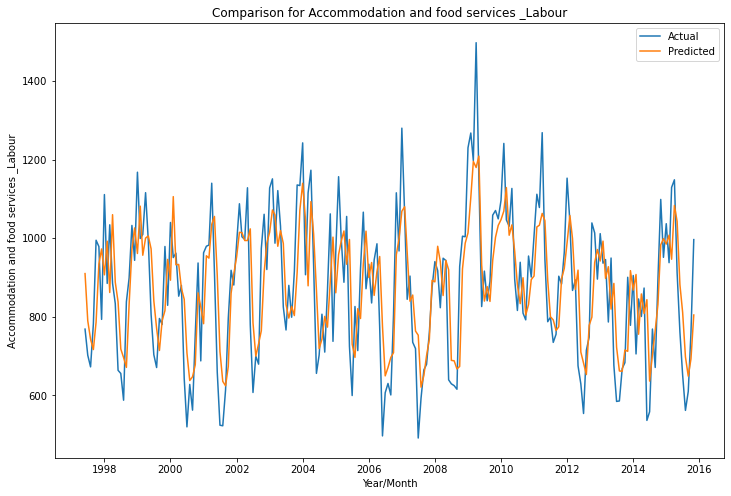

In [14]:
plot_predictions(y_pred_train_lgb,X_tn,1)

## Performing hyerperparameter search

In [15]:
#defining array for window and max_depth to make a grid.

window_size = np.arange(1,21)
max_depth = np.arange(1,6)

In [16]:
#performing grid search using perform_gridsearch function.

window_loss, window_score = perform_gridsearch(train_scaled,window_size,max_depth)

Highest accuracy was achieved for window size of 18 and max_depth of 5
Corresponding accuracy and loss were 0.9090295940663935 , 0.081365176329356 respectively.



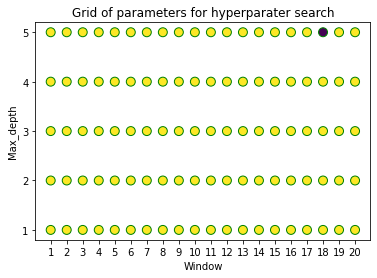

In [17]:
#A piece of code to visualize the grid results. 

#get the combination that yielded max r2-score.
scores = np.asarray(window_score)
losses = np.asarray(window_loss)
ind1 = np.unravel_index(np.argmax(scores, axis=None), scores.shape) #for finding max accuracy

print('Highest accuracy was achieved for window size of {} and max_depth of {}'.format(window_size[ind1[0]],max_depth[ind1[1]]))
print('Corresponding accuracy and loss were {} , {} respectively.\n'.format(scores[ind1],losses[ind1]))

#Make a grid for plotting the grid parameters
x,y = np.meshgrid(window_size,max_depth)
y.ravel()
x.ravel()
grid = np.transpose(np.vstack((x.ravel(),y.ravel())))

#defining a color matrix and a different color for the combination that gave good results. 
c = np.ones(grid.shape[0])
c[(ind1[1]*20) +ind1[0]] = 0

#plotting the grid
plt.scatter(x=grid[:,0],y=grid[:,1],s=80, c=c ,facecolors='none', edgecolors='g')
plt.yticks(max_depth)
plt.xticks(window_size)
plt.title('Grid of parameters for hyperparater search')
plt.xlabel('Window')
plt.ylabel('Max_depth')
plt.show()

### *Plotting gridsearch results*
* It will plot the grid search results for loss and score arrays. 
* x-axis is max_depth and y-axis is the window size array. 

<Figure size 432x288 with 0 Axes>

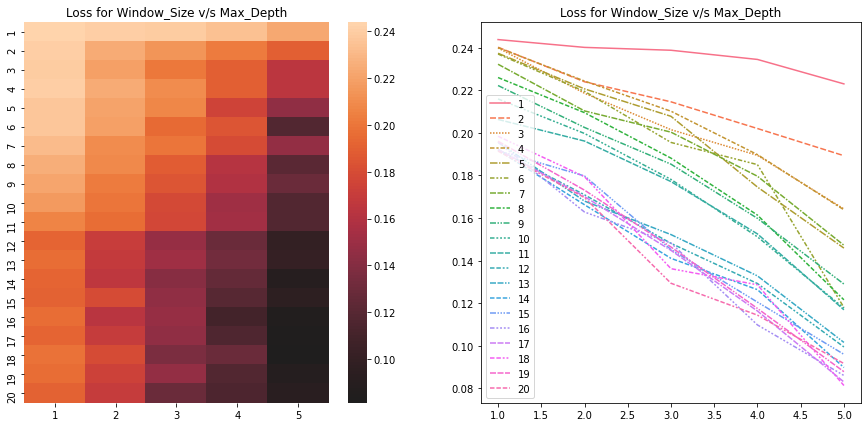

<Figure size 432x288 with 0 Axes>

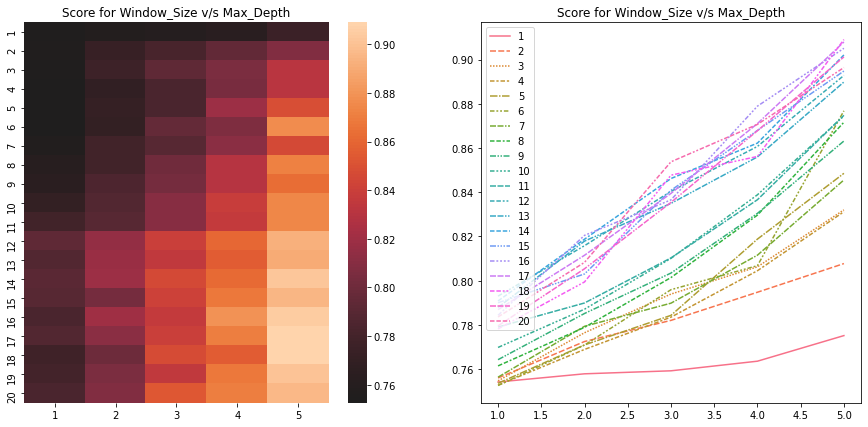

In [18]:
plot_gridsearch_results(window_loss,window_size,max_depth,'Loss for Window_Size v/s Max_Depth')
plot_gridsearch_results(window_score,window_size,max_depth,'Score for Window_Size v/s Max_Depth')

## Checking Test Accuracy

* *In order to predict all test observations, I will be taking the last window from training set.*

In [19]:
#Transforming the data using the scaler object defined earlier
test_scaled = scaler.transform(X_ts)

#Making a data frame if needed to view it in tabular structure.
df_test = pd.DataFrame(test_scaled,columns=df.columns)
df_test.insert(0,'Year/Month',X_ts.index) 
df_test.set_index('Year/Month',inplace=True)

#Taking the last window from traning data, so that each observation in test set is predicted.
#Otherwise, we won't able to predict the first 'window' samples from test set.
end = train_scaled.shape[0]
tr = train_scaled[end-window:end,:]
testing_data = np.append(tr,test_scaled,0)

#Transforming the data for supervised learning.
X_testing,Y_testing = transform_data(testing_data,window)

#Making predictions
y_pred_test_gbr = gbr.predict(X_testing)
y_pred_test_lgb = lgb.predict(X_testing)

loss_gbr = sklearn.metrics.mean_squared_error(Y_testing,y_pred_test_gbr)
score_gbr = sklearn.metrics.r2_score(Y_testing,y_pred_test_gbr)

loss_lgb = sklearn.metrics.mean_squared_error(Y_testing,y_pred_test_lgb)
score_lgb = sklearn.metrics.r2_score(Y_testing,y_pred_test_lgb)

print('Test loss for Sklearn GBDT model :- ',loss_gbr)
print('Test accuracy for Sklearn GBDT model :- ',score_gbr)

print('Test loss for LightGBM model :- ',loss_lgb)
print('Test accuracy for LightGBM model :- ',score_lgb)


Test loss for Sklearn GBDT model :-  1.5959069727866941
Test accuracy for Sklearn GBDT model :-  0.4231549820812097
Test loss for LightGBM model :-  1.4669234121263113
Test accuracy for LightGBM model :-  0.46977644913981154


### *Plotting test predictions*

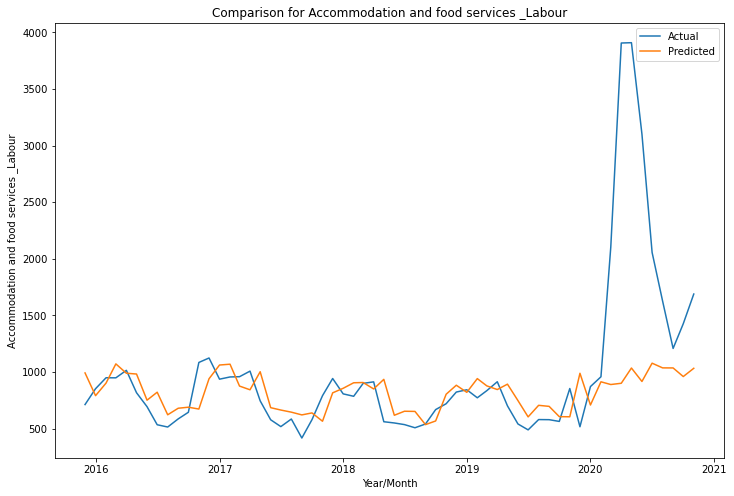

In [20]:
plot_predictions(y_pred_test_gbr,X_ts,1)

### Making a deviance plot for two reasons :

* *A good measure to visualize the loss reduction happening after each estimator is added.*
* *Gives us an idea on deciding the number of estimators required, which can save some computational cost.*
* *This plot function is rendered from sklearn user guide :- https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html*

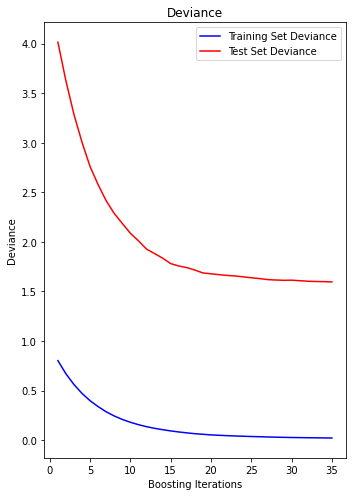

In [21]:
test_score = np.zeros(estimators, dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_testing)):
    test_score[i] = gbr.loss_(Y_testing, y_pred)

fig = plt.figure(figsize=(5, 7))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(estimators) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

## Multi-Step Prediction
*-Multi-step is making a long prediction based on current observation. E.g. Predicting for next 12 months based on current month observation.\
-Take the last window and predict based on that.\
-Then add that prediction in the window and predict next. Do not add the actual observation, otherwise its not a multi-step\
-Here the window is not a rolling window, but its an expanding window, it keeps expanding after each prediction is added as a feature to predict the next time step.*

In [22]:
#defining a period for doing a multi-prediction
#taking last window as dataset.
period =12
end = train_scaled.shape[0]
w_array = train_scaled[end-window:end,:]

#performing multi-step prediction
actuals,predictions = predict_multistep(w_array,test_scaled,period)


### Plotting multi-step predicitions. As you can see it is not giving satisfying results. 

- *One reason coulbe be, because it didn't perform great on single step prediction*
- *We are predicting 12 months for 30 industrial sectors based on last **window** observations. The window size is not enough to take such a big step for a number of industrial sectors.*

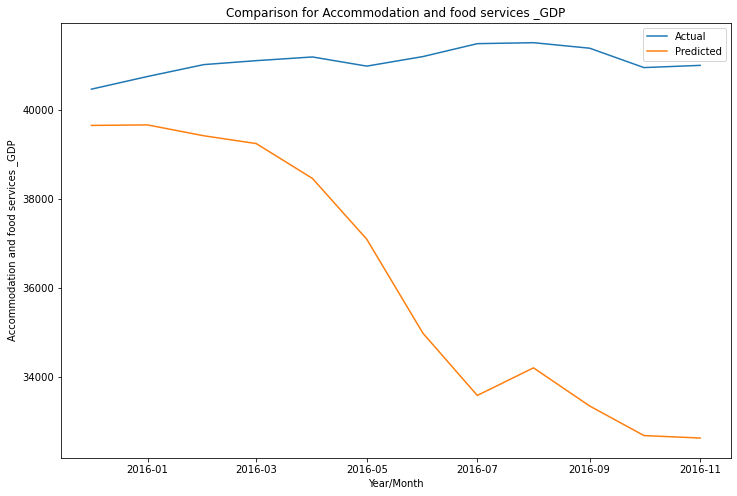

In [23]:
plot_predictions(predictions,X_ts,0)

## Performing walk forward validation

* Here we keep expanding the training set size as we move forward in time and predict & plot the results on test data. 

For split 1 the loss and R2-score are :- 0.29174451564302945, 0.4361189685753668



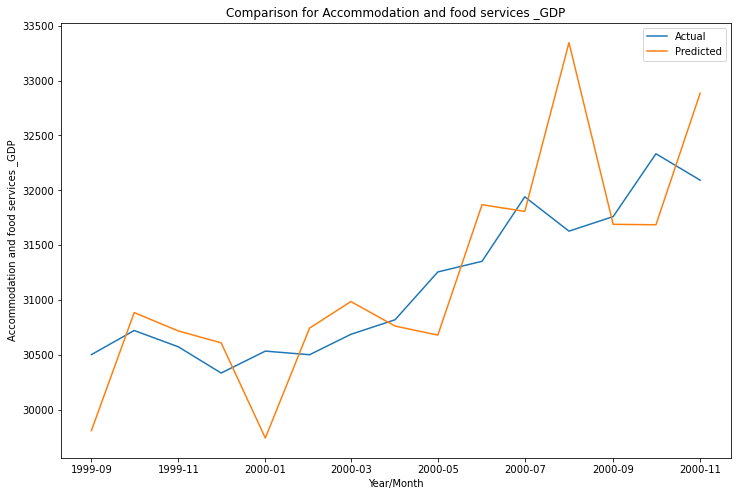

For split 2 the loss and R2-score are :- 0.4378257290619937, 0.3360394313626608



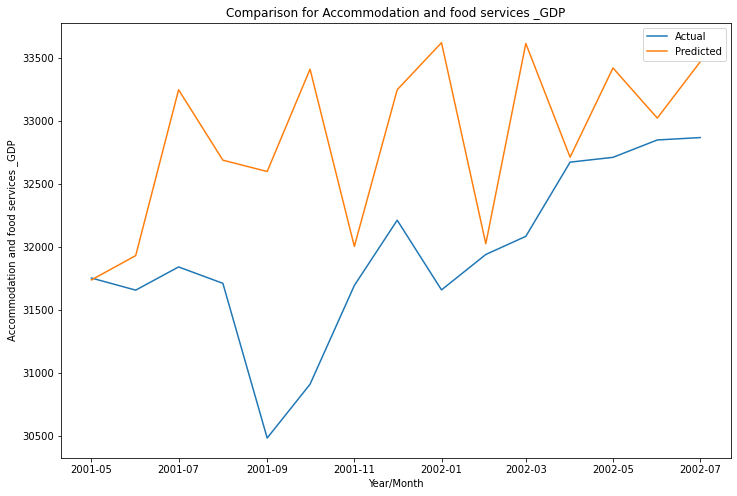

For split 3 the loss and R2-score are :- 0.22085231136996583, 0.515879090436445



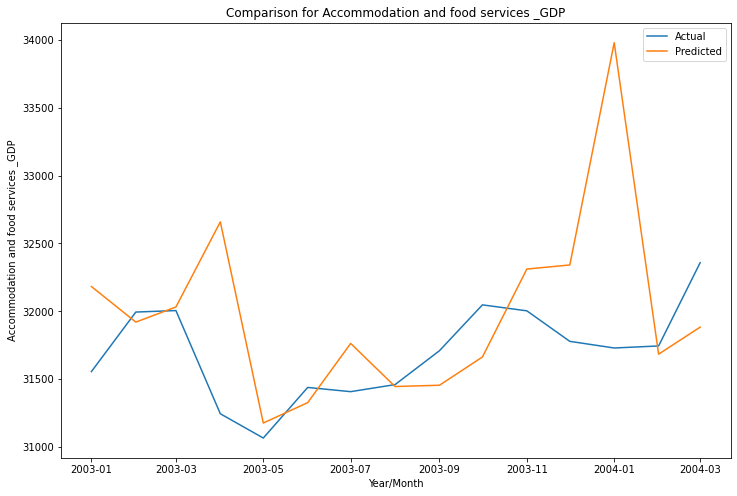

For split 4 the loss and R2-score are :- 0.3561685510214996, 0.02505211536257801



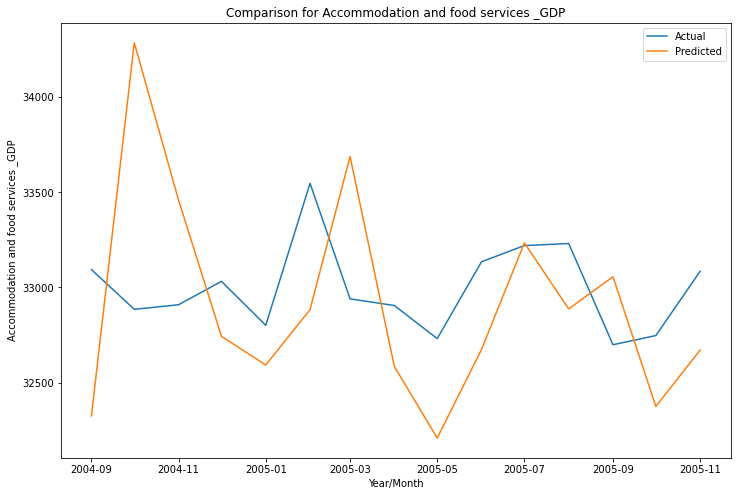

For split 5 the loss and R2-score are :- 0.2755685835530956, 0.1833224137439482



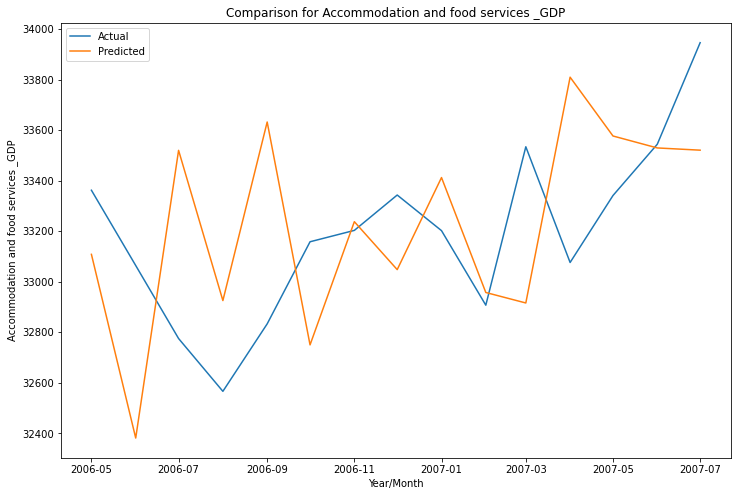

For split 6 the loss and R2-score are :- 0.2644225244222657, 0.47636623763681485



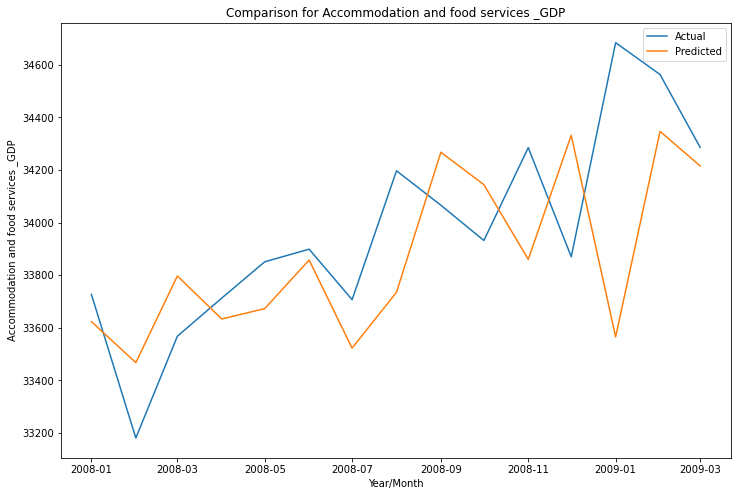

For split 7 the loss and R2-score are :- 0.25246303818069094, 0.4333300878217051



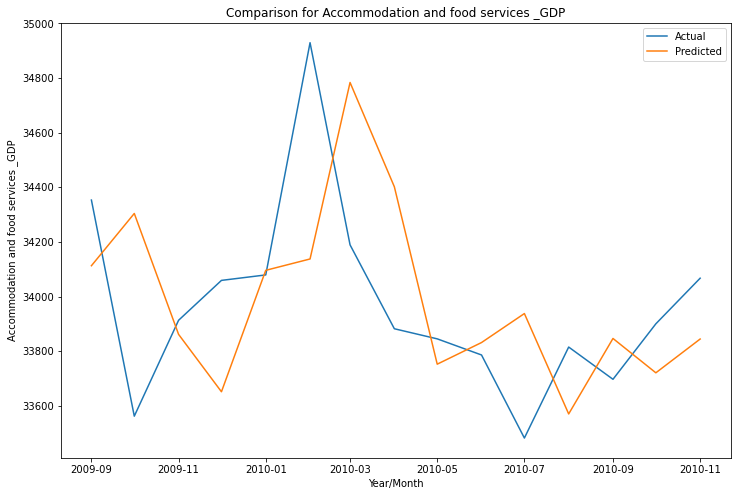

For split 8 the loss and R2-score are :- 0.2621596924721409, 0.5936661363935922



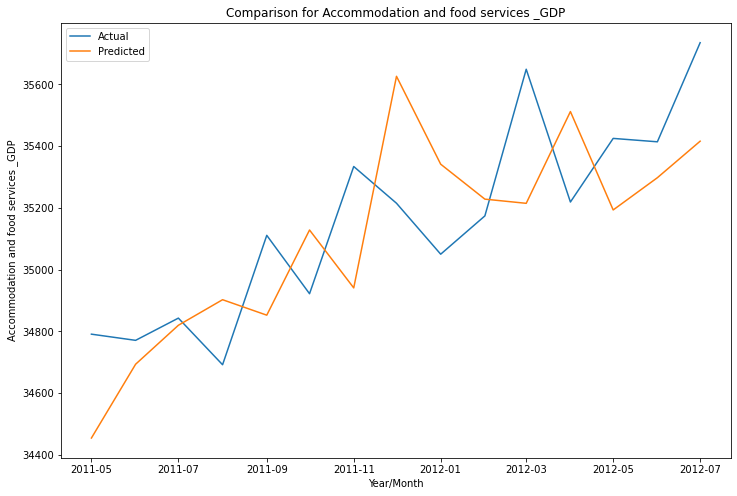

For split 9 the loss and R2-score are :- 0.27090662242522145, 0.689292955894202



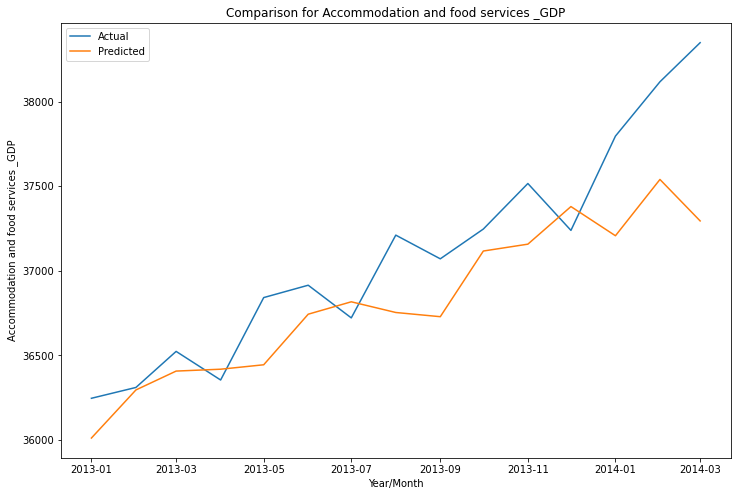

For split 10 the loss and R2-score are :- 0.4156528746474407, 0.6357587188482203



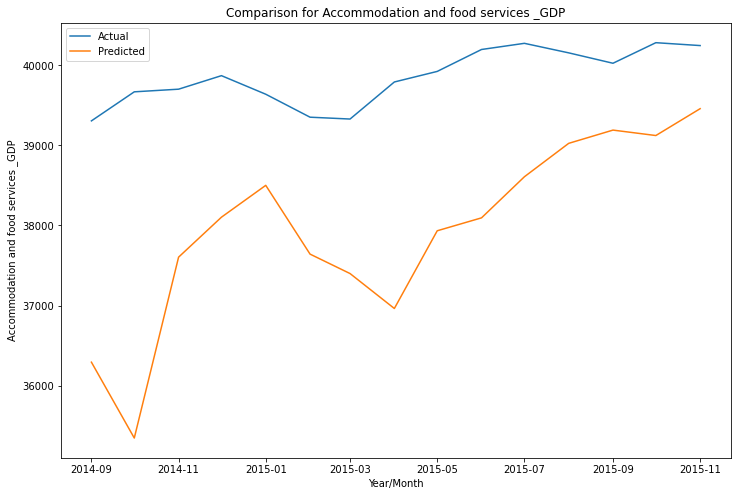

Mean r2-score achieved was :  0.43248261560755336

Mean loss achieved was :  0.3047764442797344


In [24]:
split_score,split_loss = perform_wfv(df_train,X_tn,10)
print('Mean r2-score achieved was : ', split_score.mean())
print('\nMean loss achieved was : ',split_loss.mean())

<div align="center"><h1>Thank You</h1></div>